In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
ChG_folder = '/biodata/nyanovsky/datasets/ChG/' 

In [3]:
target_decagon_df = pd.read_csv(ChG_folder+'TD/ChG-TargetDecagon_targets.csv')

### Target Decagon
- Download at: https://snap.stanford.edu/biodata/datasets/10015/10015-ChG-TargetDecagon.html
- Info at: https://academic.oup.com/bioinformatics/article/34/13/i457/5045770?login=false

In [4]:
target_decagon_df.head()

,# Drug\tGene
CID000003488,1559
CID000003488,8647
CID000077992,3351
CID000077992,3350
CID000077992,3352


In [5]:
target_decagon_df["DrugID (PubChem CID)"] = target_decagon_df.index 
target_decagon_df.rename(columns={"# Drug\tGene":"GeneID (NCBI)"}, inplace=True)
target_decagon_df.reset_index(drop=True, inplace=True)

In [6]:
target_decagon_df.head()

,GeneID (NCBI),DrugID (PubChem CID)
0,1559,CID000003488
1,8647,CID000003488
2,3351,CID000077992
3,3350,CID000077992
4,3352,CID000077992


### Comparative Toxigenomics Database (CTD)
- Info: http://ctdbase.org/
- Download: https://ctdbase.org/downloads/#cg

In [7]:
ctd_ChG_df = pd.read_csv(ChG_folder+'/ctd/ChG_ctd.csv')
ctd_ChG_df.head()

,# ChemicalName,ChemicalID,CasRN,GeneSymbol,GeneID,GeneForms,Organism,OrganismID,Interaction,InteractionActions,PubMedIDs
0,10074-G5,C534883,NaN,AR,367,protein,Homo sapiens,9606.0,10074-G5 affects the reaction [MYC protein res...,affects^reaction|increases^expression,32184358
1,10074-G5,C534883,NaN,AR,367,protein,Homo sapiens,9606.0,10074-G5 inhibits the reaction [EPHB2 protein ...,decreases^reaction|increases^expression,32184358
2,10074-G5,C534883,NaN,AR,367,protein,Homo sapiens,9606.0,10074-G5 results in decreased expression of AR...,decreases^expression,32184358
3,10074-G5,C534883,NaN,AR,367,protein,Homo sapiens,9606.0,10074-G5 results in decreased expression of AR...,decreases^expression,32184358
4,10074-G5,C534883,NaN,EPHB2,2048,protein,Homo sapiens,9606.0,10074-G5 inhibits the reaction [EPHB2 protein ...,decreases^reaction|increases^expression,32184358


In [8]:
ctd_ChG_df = ctd_ChG_df[ctd_ChG_df["Organism"].isin(["Homo sapiens", "Mus musculus"])]
ctd_ChG_df = ctd_ChG_df[ctd_ChG_df["GeneForms"]=="protein"]
ctd_ChG_df = ctd_ChG_df[ctd_ChG_df["InteractionActions"].str.contains("bind").fillna(False)]
ctd_ChG_df = ctd_ChG_df[ctd_ChG_df["GeneForms"]=="protein"]


ctd_ChG_df.drop(columns=["CasRN", "GeneForms", "OrganismID", "InteractionActions", "PubMedIDs"], inplace=True)
ctd_ChG_df.drop_duplicates(subset=["ChemicalID", "GeneID"], inplace=True) # Varias filas para un dado par (droga, gen) debido a multiples tipos de interaccion.
ctd_ChG_df.rename(columns={"ChemicalID": "DrugID (MeSH)", "GeneID": "GeneID (NCBI)"}, inplace=True)
ctd_ChG_df.reset_index(drop=True, inplace=True)
ctd_ChG_df.head()

,# ChemicalName,DrugID (MeSH),GeneSymbol,GeneID (NCBI),Organism,Interaction
0,10-deacetylpaclitaxel,C095360,ABCB1,5243,Homo sapiens,10-deacetylpaclitaxel binds to ABCB1 protein
1,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,ALB,213,Mus musculus,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...
2,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,ATP5F1B,506,Mus musculus,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...
3,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,AZGP1,563,Homo sapiens,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...
4,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,CES1C,13884,Mus musculus,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...


### MINER

 - Download at: https://snap.stanford.edu/biodata/datasets/10002/10002-ChG-Miner.html
 - info at: https://github.com/snap-stanford/miner-data

In [9]:
miner_ChG_df = pd.read_csv(ChG_folder+'miner/ChG_miner.tsv', sep='\t')
miner_ChG_df.head()

,#Drug,Gene
0,DB00357,P05108
1,DB02721,P00325
2,DB00773,P23219
3,DB07138,Q16539
4,DB08136,P24941


In [10]:
miner_ChG_df.rename(columns={"#Drug":"DrugID (DrugBank)", "Gene": "GeneID (UniProt)"}, inplace=True)

In [11]:
miner_ChG_df.head()

,DrugID (DrugBank),GeneID (UniProt)
0,DB00357,P05108
1,DB02721,P00325
2,DB00773,P23219
3,DB07138,Q16539
4,DB08136,P24941


In [12]:
miner_ChG_df.drop(index=13541,inplace=True) 

###

In [13]:
ChG_db_info = pd.DataFrame(index=["TargetDecagon", "CTD", "MINER"], columns=["DrugID type", "GeneID type", "num_nodes (total, drug, gene)", "num_edges"])
target_decagon_num_drugs, target_decagon_num_genes = len(target_decagon_df["DrugID (PubChem CID)"].unique()), len(target_decagon_df["GeneID (NCBI)"].unique())
ChG_db_info.loc["TargetDecagon"] = ["PubChem CID", "NCBI", (target_decagon_num_drugs+target_decagon_num_genes, target_decagon_num_drugs, target_decagon_num_genes), target_decagon_df.shape[0]]

ctd_num_drugs, ctd_num_genes = len(ctd_ChG_df["DrugID (MeSH)"].unique()), len(ctd_ChG_df["GeneID (NCBI)"].unique())
ChG_db_info.loc["CTD"] = ["MeSH", "NCBI", (ctd_num_drugs+ctd_num_genes, ctd_num_drugs, ctd_num_genes), ctd_ChG_df.shape[0]]

miner_num_drugs, miner_num_genes = len(miner_ChG_df["DrugID (DrugBank)"].unique()), len(miner_ChG_df["GeneID (UniProt)"].unique())
ChG_db_info.loc["MINER"] = ["DrugBank", "UniProt", (miner_num_drugs+miner_num_genes, miner_num_drugs, miner_num_genes), miner_ChG_df.shape[0]]

### Info: 

In [14]:
ChG_db_info

,DrugID type,GeneID type,"num_nodes (total, drug, gene)",num_edges
TargetDecagon,PubChem CID,NCBI,"(3932, 284, 3648)",18690
CTD,MeSH,NCBI,"(3836, 1731, 2105)",7546
MINER,DrugBank,UniProt,"(7341, 5017, 2324)",15138


### Merging: Etandarizacion a PubChem CID y Entrez ID (NCBI)
- mapping to PubChem CID: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi
- mapping to Entrez ID: https://www.uniprot.org/id-mapping

#### MINER

In [18]:
miner_drugs = miner_ChG_df["DrugID (DrugBank)"].unique()

In [38]:
def write_list_to_txt(lst, filename):
    with open(ChG_folder+filename, 'w') as file:
        for x in lst:
            file.write(f'{x}\n')

In [ ]:
write_list_to_txt(miner_drugs, 'miner_drugIDs.txt') # Then Query in PubChem to retrieve CIDs

In [16]:
miner_mappings = pd.read_csv(ChG_folder+'miner/miner_mappings.txt', sep='\t', header=None) # mappings from PubChem
miner_mappings.head()

,0,1
0,DB00357,2145.0
1,DB02721,77022.0
2,DB00773,36462.0
3,DB07138,3038525.0
4,DB08136,24864077.0


In [17]:
miner_mappings.rename(columns={0:"DrugBank ID", 1:"PubChem CID"}, inplace=True)
not_mapped = miner_mappings[miner_mappings["PubChem CID"].isna()]["DrugBank ID"]
miner_mappings.dropna(inplace=True)
miner_mappings["PubChem CID"] = miner_mappings["PubChem CID"].astype(int)

miner_ChG_df = miner_ChG_df[~miner_ChG_df["DrugID (DrugBank)"].isin(not_mapped)]

In [18]:
miner_ChG_df.head()

,DrugID (DrugBank),GeneID (UniProt)
0,DB00357,P05108
1,DB02721,P00325
2,DB00773,P23219
3,DB07138,Q16539
4,DB08136,P24941


In [19]:
mapped_miner_drugs = pd.merge(miner_ChG_df, miner_mappings, left_on="DrugID (DrugBank)", right_on= "DrugBank ID", how='left')
mapped_miner_drugs.drop(columns=["DrugBank ID"], inplace=True)
mapped_miner_drugs.rename(columns={'PubChem CID': 'DrugID (PubChem CID)'}, inplace=True)
mapped_miner_drugs.head()

,DrugID (DrugBank),GeneID (UniProt),DrugID (PubChem CID)
0,DB00357,P05108,2145
1,DB02721,P00325,77022
2,DB00773,P23219,36462
3,DB07138,Q16539,3038525
4,DB08136,P24941,24864077


In [26]:
miner_prots = miner_ChG_df["GeneID (UniProt)"].unique()
write_list_to_txt(miner_prots, 'miner/miner_protIDs.txt')

In [20]:
miner_prots_not_mapped = []
with open(ChG_folder+'miner/miner_prots_not_mapped.txt', 'r') as file:
    for line in file:
        miner_prots_not_mapped.append(line.strip())

miner_prot_mappings = pd.read_csv(ChG_folder+'miner/miner_prot_mappings.tsv', sep='\t')
miner_prot_mappings.head()

,From,To
0,P05108,1583
1,P00325,125
2,P23219,5742
3,Q16539,1432
4,P24941,1017


In [21]:
miner_prot_mappings.rename(columns={'From':'GeneID (UniProt)', 'To':'GeneID (NCBI)'}, inplace=True)
mapped_miner_drugs = mapped_miner_drugs[~mapped_miner_drugs["GeneID (UniProt)"].isin(miner_prots_not_mapped)]

mapped_miner = pd.merge(mapped_miner_drugs, miner_prot_mappings, left_on="GeneID (UniProt)", right_on="GeneID (UniProt)", how="left")
mapped_miner.head()

,DrugID (DrugBank),GeneID (UniProt),DrugID (PubChem CID),GeneID (NCBI)
0,DB00357,P05108,2145,1583
1,DB02721,P00325,77022,125
2,DB00773,P23219,36462,5742
3,DB07138,Q16539,3038525,1432
4,DB08136,P24941,24864077,1017


#### Target Decagon

##### Mapeo de GeneID a UniprotID

In [ ]:
target_decagon_genes = target_decagon_df["GeneID (NCBI)"].unique()
write_list_to_txt(target_decagon_genes, 'target_decagon_genes.txt')

In [66]:
target_decagon_mappings = pd.read_csv(ChG_folder+'target_decagon_mappings.tsv',sep="\t")
target_decagon_mappings["Gene Names"] = target_decagon_mappings["Gene Names"].str.split()
target_decagon_mappings.head()

,From,Entry,Entry Name,Gene Names
0,1559,P11712,CP2C9_HUMAN,"[CYP2C9, CYP2C10]"
1,1559,S5RV20,S5RV20_HUMAN,[CYP2C9]
2,8647,O95342,ABCBB_HUMAN,"[ABCB11, BSEP]"
3,3351,P28222,5HT1B_HUMAN,"[HTR1B, HTR1DB]"
4,3351,A8K215,A8K215_HUMAN,NaN


In [68]:
target_decagon_mappings["Entry_in_miner"] = target_decagon_mappings["Entry"].apply(lambda x: x in miner_proteins)
target_decagon_mappings.sort_values(by=["From", "Entry_in_miner"], ascending=[True,False], inplace=True)
target_decagon_mappings.drop_duplicates(subset=["From"], keep="first", inplace=True)
target_decagon_mappings.drop(columns="Entry_in_miner", inplace=True)
target_decagon_mappings.head()

,From,Entry,Entry Name,Gene Names
5951,9,P18440,ARY1_HUMAN,"[NAT1, AAC1]"
5954,10,P11245,ARY2_HUMAN,"[NAT2, AAC2]"
2075,13,P22760,AAAD_HUMAN,"[AADAC, DAC]"
2077,15,Q16613,SNAT_HUMAN,"[AANAT, SNAT]"
6132,18,P80404,GABT_HUMAN,"[ABAT, GABAT]"


In [70]:
mapped_target_decagon = pd.merge(target_decagon_df, target_decagon_mappings, left_on= "GeneID (NCBI)", right_on= "From", how='left')
mapped_target_decagon.drop(columns=["From"], inplace=True)
mapped_target_decagon.rename(columns={"Entry": "GeneID (UniProt)", "Entry Name": "UniProt Name"}, inplace=True)
mapped_target_decagon["DrugID (PubChem CID)"] = mapped_target_decagon["DrugID (PubChem CID)"].str.extract(r'CID0+(\d+)', expand=False)
mapped_target_decagon

,GeneID (NCBI),DrugID (PubChem CID),GeneID (UniProt),UniProt Name,Gene Names
0,1559,3488,P11712,CP2C9_HUMAN,"[CYP2C9, CYP2C10]"
1,8647,3488,O95342,ABCBB_HUMAN,"[ABCB11, BSEP]"
2,3351,77992,P28222,5HT1B_HUMAN,"[HTR1B, HTR1DB]"
3,3350,77992,P08908,5HT1A_HUMAN,"[HTR1A, ADRB2RL1, ADRBRL1]"
4,3352,77992,P28221,5HT1D_HUMAN,"[HTR1D, HTR1DA, HTRL]"
...,...,...,...,...,...
18685,8484,5152,O60755,GALR3_HUMAN,"[GALR3, GALNR3]"
18686,81491,5152,Q9BZJ6,GPR63_HUMAN,"[GPR63, PSP24B]"
18687,83551,5152,Q969N4,TAAR8_HUMAN,"[TAAR8, GPR102, TA5, TAR5, TRAR5]"
18688,680,5152,P32247,BRS3_HUMAN,[BRS3]


#### CTD

In [73]:
ctd_drugs = ctd_ChG_df["ChemicalID (MeSH)"].unique()
ctd_genes = ctd_ChG_df["GeneID (NCBI)"].unique()

write_list_to_txt(ctd_drugs, 'ctd_drugs.txt')

write_list_to_txt(ctd_genes, 'ctd_genes.txt')

In [22]:
ctd_drug_mappings = pd.read_csv(ChG_folder+'ctd/ctd_drug_mappings.txt', sep='\t', header=None)
ctd_drug_mappings.head()

,0,1
0,C095360,155831.0
1,C403065,24762158.0
2,C065719,54692492.0
3,C554291,12968471.0
4,C521487,24836820.0


In [24]:
ctd_drug_mappings.isna().sum()

0      0
1    151
dtype: int64

In [25]:
ctd_drug_mappings.rename(columns={0:"MeSH ID",1:"PubChem CID"}, inplace=True)
drugs_not_mapped = ctd_drug_mappings[ctd_drug_mappings["PubChem CID"].isna()]["MeSH ID"]
ctd_drug_mappings.dropna(inplace=True)
ctd_drug_mappings["PubChem CID"] = ctd_drug_mappings["PubChem CID"].astype(int)


ctd_ChG_df = ctd_ChG_df[~ctd_ChG_df["DrugID (MeSH)"].isin(drugs_not_mapped)]

In [26]:
mapped_ctd_drugs = pd.merge(ctd_ChG_df, ctd_drug_mappings, left_on='DrugID (MeSH)', right_on='MeSH ID', how='left')
mapped_ctd_drugs.drop(columns=["MeSH ID"], inplace=True)
mapped_ctd_drugs.rename(columns={"PubChem CID": "DrugID (PubChem CID)"}, inplace=True)
mapped_ctd_drugs.head()

,# ChemicalName,DrugID (MeSH),GeneSymbol,GeneID (NCBI),Organism,Interaction,DrugID (PubChem CID)
0,10-deacetylpaclitaxel,C095360,ABCB1,5243,Homo sapiens,10-deacetylpaclitaxel binds to ABCB1 protein,155831
1,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,ALB,213,Mus musculus,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,24762158
2,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,ATP5F1B,506,Mus musculus,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,24762158
3,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,AZGP1,563,Homo sapiens,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,24762158
4,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,CES1C,13884,Mus musculus,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,24762158


##### Mapeo de GeneID de CTD a UniProt ID 

In [73]:
ctd_gene_mappings = pd.read_csv(ChG_folder+'ctd_gene_mappings.tsv', sep='\t')
ctd_gene_mappings.head()

,From,Entry,Entry Name,Gene Names
0,367,P10275,ANDR_HUMAN,AR DHTR NR3C4
1,367,A0A087WUX9,A0A087WUX9_HUMAN,AR
2,367,F1D8N5,F1D8N5_HUMAN,NR3C4
3,367,G4VV16,G4VV16_HUMAN,AR8
4,367,Q9NUA2,Q9NUA2_HUMAN,NaN


In [74]:
sum(ctd_gene_mappings["Entry"].isna())

0

In [75]:
# Uniprot te devuelve los ids que no pudo mappear en el resultado del query, pero aparte, asi que hay que levantarlos de ahi.
ctd_genes_not_mapped = []
with open(ChG_folder+'ctd_genes_not_mapped.txt', 'r') as file:
    for line in file:
        ctd_genes_not_mapped.append(int(line.strip()))

In [76]:
ctd_ChG_human_df = ctd_ChG_human_df[~ctd_ChG_human_df["GeneID (NCBI)"].isin(ctd_genes_not_mapped)]

ctd_gene_mappings["Gene Names"] = ctd_gene_mappings["Gene Names"].str.split()

In [78]:
mapped_ctd = pd.merge(mapped_ctd_drugs, ctd_gene_mappings, left_on="GeneID (NCBI)", right_on="From", how='left')
mapped_ctd

,# ChemicalName,DrugID (MeSH),GeneSymbol,GeneID (NCBI),DrugID (PubChem CID),From,Entry,Entry Name,Gene Names
0,10074-G5,C534883,AR,367,2836600,367,P10275,ANDR_HUMAN,"[AR, DHTR, NR3C4]"
1,10074-G5,C534883,AR,367,2836600,367,A0A087WUX9,A0A087WUX9_HUMAN,[AR]
2,10074-G5,C534883,AR,367,2836600,367,F1D8N5,F1D8N5_HUMAN,[NR3C4]
3,10074-G5,C534883,AR,367,2836600,367,G4VV16,G4VV16_HUMAN,[AR8]
4,10074-G5,C534883,AR,367,2836600,367,Q9NUA2,Q9NUA2_HUMAN,NaN
...,...,...,...,...,...,...,...,...,...
121973,Dicofol,D004010,NR1I2,8856,8268,8856,O75469,NR1I2_HUMAN,"[NR1I2, PXR]"
121974,Dicofol,D004010,NR1I2,8856,8268,8856,F1D8P9,F1D8P9_HUMAN,"[NR1i2, NR1I2, hCG_21777]"
121975,Dicofol,D004010,NR1I3,9970,8268,9970,Q14994,NR1I3_HUMAN,"[NR1I3, CAR]"
121976,Dicofol,D004010,NR1I3,9970,8268,9970,F1DAL4,F1DAL4_HUMAN,[NR1I3]


Para sacar duplicados voy a priorizar el primer ID de la proteina que exista en las otras dos bases de datos (si no podriamos estar sumando aristas redundantes sin saberlo). En el caso en que no haya ni una entrada con una proteina ya existente, priorizo los que matcheen el GeneSymbol (que ya venia con la db) con el Gene Name (que viene del query de UniProt).

In [80]:
miner_proteins

array(['P05108', 'P00325', 'P23219', ..., 'Q96RP8', 'P41250', 'Q7Z2W7'],
      dtype=object)

In [89]:
all_other_proteins = pd.concat([mapped_target_decagon["GeneID (UniProt)"], mapped_miner["GeneID (UniProt)"]]).unique()

In [90]:
mapped_ctd["Gene Names"] = mapped_ctd["Gene Names"].apply(lambda x: [name.upper() for name in x] if isinstance(x, list) else x)

mapped_ctd["Entry_in_other_proteins"] = mapped_ctd["Entry"].apply(lambda x: x in all_other_proteins)
mapped_ctd["symbol in name"] = mapped_ctd.apply(lambda row: row["GeneSymbol"] in row["Gene Names"] if isinstance(row["Gene Names"], list) else False, axis=1)

mapped_ctd.sort_values(by=["DrugID (MeSH)", "GeneID (NCBI)", "Entry_in_other_proteins", "symbol in name"], ascending=[True, True, False, False], inplace=True)
mapped_ctd.drop_duplicates(subset=["DrugID (MeSH)", "GeneID (NCBI)"], keep="first", inplace=True)
mapped_ctd.drop(columns=["From","Entry_in_other_proteins", "symbol in name"], inplace=True)
mapped_ctd.rename(columns={"Entry": "GeneID (UniProt)", "Entry Name": "UniProt name"}, inplace=True)
mapped_ctd.reset_index(inplace=True, drop=True)

#### Merging

In [28]:
mapped_miner

,DrugID (DrugBank),GeneID (UniProt),DrugID (PubChem CID),GeneID (NCBI)
0,DB00357,P05108,2145,1583
1,DB02721,P00325,77022,125
2,DB00773,P23219,36462,5742
3,DB07138,Q16539,3038525,1432
4,DB08136,P24941,24864077,1017
...,...,...,...,...
14073,DB00208,P10635,5472,1565
14074,DB01215,P47870,3261,2561
14075,DB01614,P21728,6077,1812
14076,DB00582,P08684,71616,1576


In [29]:
mapped_ctd_drugs

,# ChemicalName,DrugID (MeSH),GeneSymbol,GeneID (NCBI),Organism,Interaction,DrugID (PubChem CID)
0,10-deacetylpaclitaxel,C095360,ABCB1,5243,Homo sapiens,10-deacetylpaclitaxel binds to ABCB1 protein,155831
1,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,ALB,213,Mus musculus,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,24762158
2,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,ATP5F1B,506,Mus musculus,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,24762158
3,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,AZGP1,563,Homo sapiens,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,24762158
4,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,C403065,CES1C,13884,Mus musculus,10-(fluoroethoxyphosphinyl)-N-(biotinamidopent...,24762158
...,...,...,...,...,...,...,...
6709,dicloran,C004354,THRB,7068,Homo sapiens,dicloran binds to and results in increased act...,7430
6710,Dicofol,D004010,ALB,213,Homo sapiens,Dicofol binds to and affects the folding of AL...,8268
6711,Dicofol,D004010,AR,367,Homo sapiens,Dicofol binds to AR protein,8268
6712,Dicofol,D004010,ESR1,2099,Homo sapiens,Dicofol binds to and results in increased acti...,8268


In [30]:
mapped_miner["DrugID (PubChem CID)"].astype(str).str.startswith('0').sum()

0

In [31]:
target_decagon_df["DrugID (PubChem CID)"] = target_decagon_df["DrugID (PubChem CID)"].str.extract(r'CID0+(\d+)', expand=False)
target_decagon_df

,GeneID (NCBI),DrugID (PubChem CID)
0,1559,3488
1,8647,3488
2,3351,77992
3,3350,77992
4,3352,77992
...,...,...
18685,8484,5152
18686,81491,5152
18687,83551,5152
18688,680,5152


In [32]:
standarized_ctd = mapped_ctd_drugs[["DrugID (PubChem CID)", "GeneID (NCBI)"]]
standarized_miner = mapped_miner[["DrugID (PubChem CID)", "GeneID (NCBI)"]]
standarized_target_decagon = target_decagon_df[["DrugID (PubChem CID)", "GeneID (NCBI)"]]

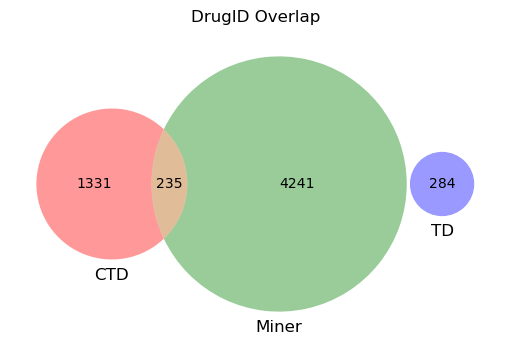

In [33]:
from matplotlib_venn import venn2, venn3

drugs_ctd = set(standarized_ctd["DrugID (PubChem CID)"])
drugs_miner = set(standarized_miner["DrugID (PubChem CID)"])
drugs_td = set(standarized_target_decagon["DrugID (PubChem CID)"])

# Draw Venn diagram for DrugIDs
plt.figure(figsize=(8, 4))
venn3([drugs_ctd, drugs_miner, drugs_td], ('CTD', 'Miner', 'TD'))
plt.title('DrugID Overlap')
plt.show()

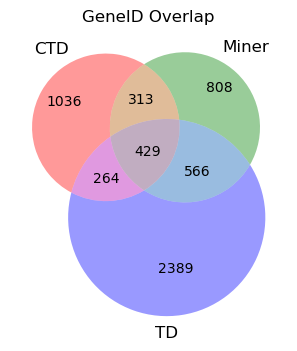

In [34]:
genes_ctd = set(standarized_ctd["GeneID (NCBI)"])
genes_miner = set(standarized_miner["GeneID (NCBI)"])
genes_td = set(standarized_target_decagon["GeneID (NCBI)"])

# Draw Venn diagram for GeneIDs
plt.figure(figsize=(8, 4))
venn3([genes_ctd, genes_miner, genes_td], ('CTD', 'Miner', 'TD'))
plt.title('GeneID Overlap')
plt.show()

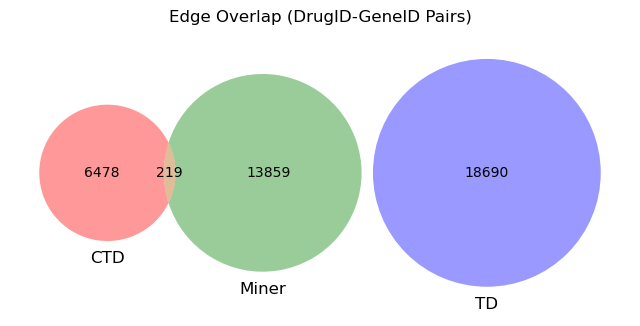

In [35]:
edges_ctd = set(standarized_ctd.apply(tuple, axis=1))
edges_miner = set(standarized_miner.apply(tuple, axis=1))
edges_td = set(standarized_target_decagon.apply(tuple, axis=1))

# Draw Venn diagram for edges
plt.figure(figsize=(8, 4))
venn3([edges_ctd, edges_miner, edges_td], ('CTD', 'Miner', 'TD'))
plt.title('Edge Overlap (DrugID-GeneID Pairs)')
plt.show()

In [36]:
ChG_df = pd.concat([standarized_ctd, standarized_miner, standarized_target_decagon]).drop_duplicates()
ChG_df.head()

,DrugID (PubChem CID),GeneID (NCBI)
0,155831,5243
1,24762158,213
2,24762158,506
3,24762158,563
4,24762158,13884


In [37]:
ChG_df.to_csv(ChG_folder+'ChG_df.csv', index=False)

In [39]:
all_drugs = ChG_df["DrugID (PubChem CID)"].unique()
write_list_to_txt(all_drugs, "all_ChG_drugs.txt")